In [1]:
from sklearn.model_selection import GroupKFold, cross_val_score, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
import os, glob, re, json
from os.path import join
import numpy as np
import pandas as pd
from nilearn import image, masking, maskers, plotting
from nilearn.image import resample_to_img, math_img, new_img_like
from datetime import datetime
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import h5py

/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


In [2]:
def extract_metadata(filenames):
    pattern = re.compile(
        r"sub-(?P<sub>\d+)_"
        r"ses-(?P<ses>\d+)_"
        r"run-(?P<run>\d+)_"
        r"runtype-(?P<runtype>\w+)_"
        r"event-(?P<event>\w+)_"
        r"trial-(?P<trial>\d+)_"
        r"cuetype-(?P<cuetype>\w+)_"
        r"stimintensity-(?P<stimintensity>\w+)"
    )
    metadata_list = []
    for filename in filenames:
        match = pattern.search(filename)
        if match:
            metadata = match.groupdict()
            metadata_list.append(metadata)
    return pd.DataFrame(metadata_list)

In [3]:
def plot_scores(X_train_r, Y_train_r,
                X_test_r, Y_test_r):

    # 1) On diagonal plot X vs Y scores on each components
    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.scatter(X_train_r[:, 0], Y_train_r[:, 0], label="train",
                marker="o", c="b", s=25)
    plt.scatter(X_test_r[:, 0], Y_test_r[:, 0], label="test",
                marker="o", c="r", s=25)
    plt.xlabel("X comp. 1")
    plt.ylabel("Y comp. 1")
    plt.title('Comp. 1: X vs Y (test corr = %.2f)' %
              np.corrcoef(X_test_r[:, 0], Y_test_r[:, 0])[0, 1])
    plt.xticks(())
    plt.yticks(())
    plt.legend(loc="best")

    plt.subplot(224)
    plt.scatter(X_train_r[:, 1], Y_train_r[:, 1], label="train",
                marker="o", c="b", s=25)
    plt.scatter(X_test_r[:, 1], Y_test_r[:, 1], label="test",
                marker="o", c="r", s=25)
    plt.xlabel("X comp. 2")
    plt.ylabel("Y comp. 2")
    plt.title('Comp. 2: X vs Y (test corr = %.2f)' %
              np.corrcoef(X_test_r[:, 1], Y_test_r[:, 1])[0, 1])
    plt.xticks(())
    plt.yticks(())
    plt.legend(loc="best")

    # 2) Off diagonal plot components 1 vs 2 for X and Y
    plt.subplot(222)
    plt.scatter(X_train_r[:, 0], X_train_r[:, 1], label="train",
                marker="*", c="b", s=50)
    plt.scatter(X_test_r[:, 0], X_test_r[:, 1], label="test",
                marker="*", c="r", s=50)
    plt.xlabel("X comp. 1")
    plt.ylabel("X comp. 2")
    plt.title('X comp. 1 vs X comp. 2 (test corr = %.2f)'
              % np.corrcoef(X_test_r[:, 0], X_test_r[:, 1])[0, 1])
    plt.legend(loc="best")
    plt.xticks(())
    plt.yticks(())

    plt.subplot(223)
    plt.scatter(Y_train_r[:, 0], Y_train_r[:, 1], label="train",
                marker="*", c="b", s=50)
    plt.scatter(Y_test_r[:, 0], Y_test_r[:, 1], label="test",
                marker="*", c="r", s=50)
    plt.xlabel("Y comp. 1")
    plt.ylabel("Y comp. 2")
    plt.title('Y comp. 1 vs Y comp. 2 , (test corr = %.2f)'
              % np.corrcoef(Y_test_r[:, 0], Y_test_r[:, 1])[0, 1])
    plt.legend(loc="best")
    plt.xticks(())
    plt.yticks(())
    plt.show()

# 0. load data

# if brain data exists, go to step 6.

In [22]:
imgfname = "/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz"
ref_img = image.load_img(imgfname)
mask = image.load_img(
    "/dartfs-hpc/rc/lab/C/CANlab/modules/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii"
)
mask_img = masking.compute_epi_mask(
    mask, target_affine=ref_img.affine, target_shape=ref_img.shape
)

# 1) convert to 4d
# original_shape = mask_img.shape  # This should be the spatial shape of the brain volume
# array_4d = array_2d.reshape(original_shape + (-1,))

# # 2) apply masker
# affine = mask_img.affine  # Assuming your data shares the same space as the mask
# func_4d = nib.Nifti1Image(reordered_4d, affine)


# Apply the mask using NiftiMasker
nifti_masker = maskers.NiftiMasker(
    mask_img=mask_img,
    smoothing_fwhm=6,
    target_affine=ref_img.affine,
    target_shape=ref_img.shape,
)

masked_func = nifti_masker.fit_transform(ref_img)

In [4]:
singletrial_dir = "/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy"
task = "*"

# 1. load single trial data from nifti

In [ ]:
import glob
from nilearn import image

# Replace 'your_directory_path' with the path to your NIfTI images
singletrial_dir = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/singletrial'
# file_pattern = 'your_directory_path/*.nii.gz' # or '*.nii' depending on your file format
flist = sorted(
    glob.glob(
        join(singletrial_dir, "sub-*", f"*runtype-{task}_event-*_cuetype-*.nii.gz"),
        recursive=True,
    )
)

# Check if you have the expected number of files
print(f"Found {len(flist)} NIfTI files.")

# Load the images (this might take some time depending on the size and number of files)
nifti_images = [image.load_img(f) for f in flist]

# Concatenate the images into a single 4D image
nifti_4d_image = image.concat_imgs(nifti_images)

# nifti_4d_image is now a 4D NIfTI image


In [28]:
from nilearn import image
import numpy as np

# Assuming 'nifti_images' is your list of 3D NIfTI images

# Number of images per chunk
chunk_size = len(nifti_images) // 3

# Create three chunks
chunks = [nifti_images[i:i + chunk_size] for i in range(0, len(nifti_images), chunk_size)]

# Concatenate images in each chunk to create three 4D images
nifti_4d_images = [image.concat_imgs(chunk) for chunk in chunks]

# nifti_4d_images is now a list of three 4D NIfTI images


In [29]:
nifti_4d_images

### save nifti to file

In [ ]:
import nibabel as nib

output_filename = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/singletrial'

# Save the image
nifti_4d_image.to_filename(output_filename)

print(f"Image saved as {output_filename}")


# 2. apply nifti

In [9]:
imgfname = "/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz"
ref_img = image.load_img(imgfname)
mask = image.load_img(
    "/dartfs-hpc/rc/lab/C/CANlab/modules/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii"
)
mask_img = masking.compute_epi_mask(
    mask, target_affine=ref_img.affine, target_shape=ref_img.shape
)

# 1) convert to 4d
# original_shape = mask_img.shape  # This should be the spatial shape of the brain volume
# array_4d = array_2d.reshape(original_shape + (-1,))

# # 2) apply masker
# affine = mask_img.affine  # Assuming your data shares the same space as the mask
# func_4d = nib.Nifti1Image(reordered_4d, affine)


# Apply the mask using NiftiMasker
nifti_masker = maskers.NiftiMasker(
    mask_img=mask_img,
    smoothing_fwhm=6,
    target_affine=ref_img.affine,
    target_shape=ref_img.shape,
)

masked_func = nifti_masker.fit_transform(nifti_4d_image)
braindf = masked_func

In [30]:
from nilearn.input_data import NiftiMasker
import pandas as pd

# Assuming you have your mask_img from the previous steps
nifti_masker = NiftiMasker(
    mask_img=mask_img,
    smoothing_fwhm=6,
    target_affine=ref_img.affine,
    target_shape=ref_img.shape,
)

# Apply the mask to each 4D image
masked_funcs = [nifti_masker.fit_transform(nifti_4d) for nifti_4d in nifti_4d_images]

# Convert the masked data to DataFrames
braindfs = [pd.DataFrame(masked_func) for masked_func in masked_funcs]

# 'braindfs' is now a list of DataFrames with the masked functional data


/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [34]:
braindfs[0]

,0,1,2,3,4,5,6,7,8,9,...,98043,98044,98045,98046,98047,98048,98049,98050,98051,98052
0,-0.065468,-0.006100,0.207872,0.719617,0.857839,0.239298,-0.134297,0.072514,-0.004950,-0.014550,...,0.235673,-0.039714,0.520198,0.885522,0.945166,0.599040,0.809102,1.375385,1.568981,1.354129
1,-0.696701,-0.192708,-0.733554,-1.553807,-2.172638,-1.982459,-1.449265,-1.033108,0.006843,-0.084132,...,-0.067850,-0.006488,0.310777,-0.205567,-0.617831,-0.599625,0.079734,-0.764778,-1.330110,-1.014080
2,-0.299182,0.087474,0.294977,0.587965,0.348965,-0.520098,-0.759845,0.196799,0.015831,0.060476,...,0.273627,-0.164865,0.101617,0.334117,0.417706,0.020995,0.211310,0.482522,0.420485,0.211810
3,-1.887556,-0.264798,-0.936744,-2.078401,-3.320682,-3.773111,-2.708043,-1.261999,-0.061994,-0.390935,...,0.075916,-0.358835,0.276032,0.127561,-0.322908,-0.734513,0.038448,-0.458549,-0.999117,-1.474578
4,0.833689,0.150017,0.159218,-0.208252,-0.781992,-0.832182,-0.212756,0.172076,0.049549,0.137005,...,-0.254380,-0.389139,-0.273629,-0.375461,-0.339091,-0.316102,-0.144539,-0.126967,-0.115009,0.229037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12947,-4.767931,-1.044272,-1.184932,-1.246495,-2.241564,-4.454995,-6.431962,-6.015547,-1.169536,-1.424569,...,-0.603596,-1.033832,-0.088377,-0.420105,-1.037109,-1.433941,-0.138225,-0.618774,-1.303022,-0.529852
12948,-0.148419,-0.003541,0.097318,0.025484,-0.198400,-0.314225,-0.261375,-0.209107,0.021465,0.056005,...,0.091459,0.195052,-0.005442,0.002714,0.053097,0.119958,-0.011040,-0.002078,0.045369,0.008035
12949,0.237772,0.161378,0.250422,0.224374,0.139092,0.188979,0.233989,0.093746,0.185128,0.188033,...,0.162999,0.326394,0.016262,0.051761,0.157362,0.273584,0.014730,0.037402,0.107196,0.001964
12950,0.238433,0.133298,0.064068,0.020866,0.084770,0.183017,0.141888,-0.075141,0.230925,0.256505,...,0.087375,0.166809,0.012338,0.042627,0.080004,0.091403,0.010320,0.045055,0.086856,0.020651


In [42]:
concatenated_df = pd.concat(braindfs, axis=0)

# Convert the concatenated DataFrame to a NumPy array
braindf = concatenated_df.to_numpy()

In [43]:
braindf.shape

(38856, 98053)

# 3. for given brain data, find behavioral data

In [37]:
print("3. for given brain data, find behavioral data")
pattern = re.compile(r"sub-(\d+).*ses-(\d+).*run-(\d+)")
unique_combinations = set()  # Extract unique combinations using a set to store them
# flist = metadata['filelist']
for file in flist:
    match = pattern.search(file)
    if match:
        # Extract sub, ses, and run numbers and add to the set as a tuple
        unique_combinations.add(
            (int(match.group(1)), int(match.group(2)), int(match.group(3)))
        )
        
unique_combinations_list = sorted(list(unique_combinations))

# print(unique_combinations_list)

3. for given brain data, find behavioral data


In [38]:
unique_combinations_list[:6]

[(2, 3, 1), (2, 3, 2), (2, 3, 3), (2, 3, 5), (2, 3, 6), (2, 4, 1)]

# 4. load behavioral file

In [39]:
beh_dir = "/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/data/beh/beh03_bids"  # "/Volumes/spacetop_projects_cue/data/beh/beh03_bids"
beh_dfs = []
for sub, ses, run in sorted(unique_combinations_list):
    beh_pattern = join(
        beh_dir,
        f"sub-{sub:04d}",
        f"ses-{ses:02d}",
        f"sub-{sub:04d}_ses-{ses:02d}_task-cue_*run-{run:02d}_runtype-*_events.tsv",
    )
    beh_files = glob.glob(beh_pattern)
    if beh_files:
        beh_fname = beh_files[0]
        bdf = pd.read_csv(
            beh_fname, sep="\t"
        )  # Make sure to use the correct separator, e.g., '\t' for TSV files
        beh_dfs.append(bdf)

stacked_df = pd.concat(beh_dfs, ignore_index=True)

# basenames = [os.path.basename(fpath) for fpath in flist]
# matching_rows = stacked_df[stacked_df['singletrial_fname'].isin(basenames)]


basenames = [os.path.basename(fpath).replace(".nii.gz", "") for fpath in flist]
# Remove the '.nii.gz' extension from 'singletrial_fname' in the DataFrame
stacked_df["singletrial_fname_no_ext"] = stacked_df["singletrial_fname"].str.replace(
    ".nii.gz", "", regex=False
)
# Now, find the rows in the DataFrame where singletrial_fname_no_ext matches the basenames without extension
intersection_beh = stacked_df[stacked_df["singletrial_fname_no_ext"].isin(basenames)]


In [40]:
intersection_beh.head()

,onset,duration,trial_type,sub,ses,run,runtype,eventtype,trialnum,cuetype,stimtype,expectrating,outcomerating,singletrial_fname,singletrial_fname_no_ext
0,11.61111,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,0,low_cue,low_stim,NaN,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...
1,42.40593,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,1,high_cue,med_stim,NaN,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...
2,74.20112,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,2,high_cue,low_stim,53.370840,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...
3,110.61470,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,3,high_cue,high_stim,36.869898,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...
4,139.90896,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,4,low_cue,med_stim,32.254711,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...


# 5. merge brain and behavioral data

In [41]:
print("5. merge brain and behavioral data")
import os
import pandas as pd

# Assuming 'df' is your existing DataFrame with a 'singletrial_fname' column
# And 'flist' is your list of file paths
# 1) Remove the '.npy' extension and sort the list
# 2) Create a DataFrame from sorted basenames
# 3) Remove the '.nii.gz' extension from 'singletrial_fname' and sort the DataFrame
sorted_basenames = sorted(os.path.basename(f).replace(".nii.gz", "") for f in flist)
basenames_df = pd.DataFrame(sorted_basenames, columns=["basename"])
stacked_df["basename"] = stacked_df["singletrial_fname"].str.replace(
    ".nii.gz", "", regex=False
)
sorted_df = stacked_df.sort_values(by="basename").reset_index(drop=True)

# Merge the two DataFrames based on the basename to ensure the order is the same
merged_df = pd.merge(basenames_df, sorted_df, on="basename", how="left")
print(merged_df)

5. merge brain and behavioral data
                                                basename      onset  duration  \
0      sub-0002_ses-03_run-01_runtype-vicarious_event...   11.61111       1.0   
1      sub-0002_ses-03_run-01_runtype-vicarious_event...   42.40593       1.0   
2      sub-0002_ses-03_run-01_runtype-vicarious_event...   74.20112       1.0   
3      sub-0002_ses-03_run-01_runtype-vicarious_event...  110.61470       1.0   
4      sub-0002_ses-03_run-01_runtype-vicarious_event...  139.90896       1.0   
...                                                  ...        ...       ...   
38851  sub-0133_ses-04_run-06_runtype-cognitive_event...  244.91100       5.0   
38852  sub-0133_ses-04_run-06_runtype-cognitive_event...  280.80772       5.0   
38853  sub-0133_ses-04_run-06_runtype-cognitive_event...  307.90116       5.0   
38854  sub-0133_ses-04_run-06_runtype-cognitive_event...  342.89754       5.0   
38855  sub-0133_ses-04_run-06_runtype-cognitive_event...  376.20997       

In [15]:
merged_df["stim_con"] = merged_df["stimtype"].replace(
    {"high_stim": 1, "med_stim": 0, "low_stim": -1}
)

In [16]:
assert len(braindf) == len(
    merged_df
), "The matrix and dataframe must have the same number of rows"
# Create a new column in 'merged_df' that uniquely identifies each session
merged_df["session_id"] = (
    merged_df[["sub", "ses", "run"]].astype(str).agg("_".join, axis=1)
)

# Prepare an array to hold the z-scored brain data
zscored_braindf = np.empty_like(braindf)
# Assuming 'run_id' is a column in 'merged_df' that uniquely identifies each run
# and 'braindf' is a pandas DataFrame with the same index as 'merged_df'
# Create an array to hold the column means for each run
column_means_per_run = np.zeros_like(braindf)
session_ids = merged_df["session_id"].unique()

# Calculate the column means for each run and fill NaN values
for session_id in session_ids:
    indices = np.where(merged_df["session_id"] == session_id)[
        0
    ]  # Get the indices for the current run
    column_means = np.nanmean(
        braindf[indices], axis=0
    )  # Calculate the mean of each column for the current run, ignoring NaNs
    # If a whole column is NaNs, fill it with zeros or a global mean if preferred
    column_means = np.nan_to_num(
        column_means, nan=0.0
    )  # or replace 0.0 with a global mean
    # Assign the means to the corresponding places in the column means array
    column_means_per_run[indices] = column_means
# Where braindf is NaN, fill in the values from column_means_per_run
braindf_filled = np.where(np.isnan(braindf), column_means_per_run, braindf)

# plot brain data

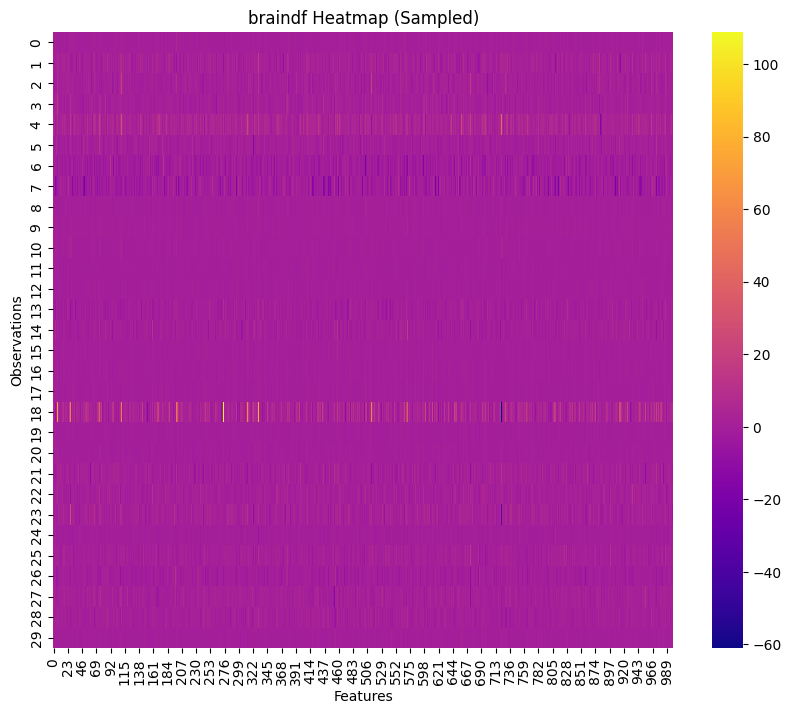

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming braindf_filled is a NumPy array
n_rows, n_cols = braindf.shape

# Number of rows and columns to sample
sample_size_rows = 30  # Adjust as needed
sample_size_cols = 1000  # Adjust as needed

# Randomly choose indices
rows_indices = np.random.choice(n_rows, sample_size_rows, replace=False)
cols_indices = np.random.choice(n_cols, sample_size_cols, replace=False)

# Sample the array
sampled_array = braindf[np.ix_(rows_indices, cols_indices)]

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(sampled_array, cmap="plasma", cbar=True)
plt.title("braindf Heatmap (Sampled)")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()


## save brain data

In [55]:
import h5py

# Assuming 'your_array' is your NumPy array

with h5py.File('/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/pls/singletrial_pvc.h5', 'w') as hdf:
    hdf.create_dataset('singletrial', data=braindf)


### save behavioral data

In [58]:
import pandas as pd

# Assuming 'df' is your DataFrame
merged_df.to_csv('/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/pls/singletrial_pvc.csv', index=False)  # Set index=False if you don't want to save the index


# 6. load brain/beh data

Here, I'm loading the saved brain and behavioral data. 
This was accomplished using steps 1,2,3,4,5 listed above.
The brain data is shaped (single trial, voxel).
Note that the voxels are smaller than the native space cube size, give that we masked out the non-brain voxels.
We can always inverse mask and revert back to nifti native space using nifti masker object.

As for the brain data, the shape is (single trial, behavioral regressors)


In [4]:
with h5py.File('/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/pls/singletrial_pvc.h5', 'r') as hdf:
    braindf_test = hdf['singletrial'][:]


In [5]:
braindf_test.shape

(38856, 98053)

In [6]:
braindf = braindf_test

In [7]:
merged_df = pd.read_csv('/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/pls/singletrial_pvc.csv')


In [8]:
print(merged_df.shape)
merged_df.head()

(38856, 20)


,basename,onset,duration,trial_type,sub,ses,run,runtype,eventtype,trialnum,cuetype,stimtype,expectrating,outcomerating,singletrial_fname,singletrial_fname_no_ext,pain_cue,vic_cue,cog_cue,gen_cue
0,sub-0002_ses-03_run-01_runtype-vicarious_event...,11.61111,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,0,low_cue,low_stim,NaN,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,-1,0,-1
1,sub-0002_ses-03_run-01_runtype-vicarious_event...,42.40593,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,1,high_cue,med_stim,NaN,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,1,0,1
2,sub-0002_ses-03_run-01_runtype-vicarious_event...,74.20112,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,2,high_cue,low_stim,53.370840,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,1,0,1
3,sub-0002_ses-03_run-01_runtype-vicarious_event...,110.61470,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,3,high_cue,high_stim,36.869898,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,1,0,1
4,sub-0002_ses-03_run-01_runtype-vicarious_event...,139.90896,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,4,low_cue,med_stim,32.254711,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,-1,0,-1


# plot behavioral data

We're going to grab a subset of regressors. Here's just a demo of the regressors we can grab.
It has 
* 1) stimulus, inserted as a contrast code,
* 2) expectation rating, not yet z scored
* 3) outcome rating, not yet z scored.


In [18]:
Xinterim = merged_df[
    ["stim_con", "expectrating", "outcomerating"]
] 
# TODO: create dummy variables for pain, vicarious, cognitive, general stim
# TODO: create dummy variables for pain, vicarious, cognitive high cue gt low cue

Yinterim = braindf  # zscored_braindf  # np.random.randn(89, 1)      # Replace with your actual data
# identify groups
from collections import Counter

subject_ids = [int(re.search(r"sub-(\d+)", fname).group(1)) for fname in flist]
subject_counts = Counter(subject_ids)  # Count the occurrences of each subject
factorized_ids, unique_ids = pd.factorize(subject_ids)
groupsinterim = (
    factorized_ids + 1
) 

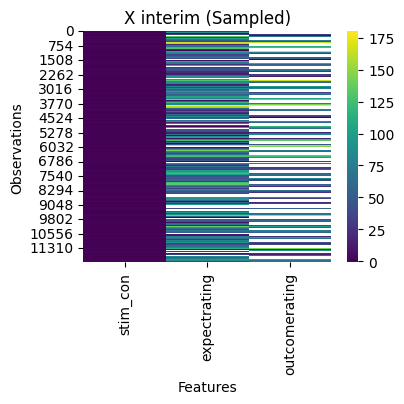

In [19]:

# Plotting
plt.figure(figsize=(4,3))
sns.heatmap(Xinterim, cmap="viridis", cbar=True)
plt.title("X interim (Sampled)")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()


# A. ANALYSIS for PVC stimulus

## create dummy contrasts for pain, vicarious, cognitive PLS
We want to separate the pain vicarious cognitive runs using PLS. It may overkill, but it will useful to see whether it produces a similar map to the univariate analyses.

In [10]:
dummy_vars = pd.get_dummies(merged_df['runtype'])
merged_df = pd.concat([merged_df, dummy_vars], axis=1)
# rename the dummy columns for clarity:
merged_df.rename(columns={'pain': 'dummy_pain', 'vicarious': 'dummy_vicarious', 'cognitive': 'dummy_cognitive'}, inplace=True)
# adding domain general regressor
merged_df['dummy_general'] = 1


In [11]:
merged_df.head()

,basename,onset,duration,trial_type,sub,ses,run,runtype,eventtype,trialnum,...,singletrial_fname,singletrial_fname_no_ext,pain_cue,vic_cue,cog_cue,gen_cue,dummy_cognitive,dummy_pain,dummy_vicarious,dummy_general
0,sub-0002_ses-03_run-01_runtype-vicarious_event...,11.61111,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,0,...,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,-1,0,-1,0,0,1,1
1,sub-0002_ses-03_run-01_runtype-vicarious_event...,42.40593,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,1,...,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,1,0,1,0,0,1,1
2,sub-0002_ses-03_run-01_runtype-vicarious_event...,74.20112,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,2,...,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,1,0,1,0,0,1,1
3,sub-0002_ses-03_run-01_runtype-vicarious_event...,110.61470,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,3,...,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,1,0,1,0,0,1,1
4,sub-0002_ses-03_run-01_runtype-vicarious_event...,139.90896,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,4,...,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,-1,0,-1,0,0,1,1


### A.1 plot behavioral data

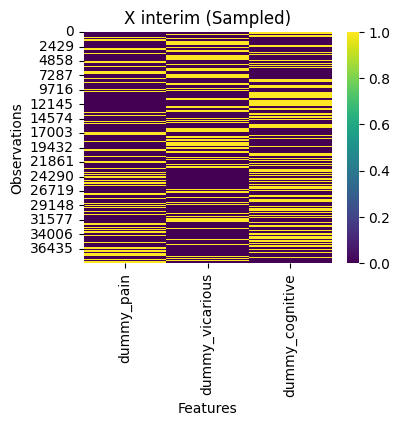

In [12]:
Xinterim = merged_df[
    ["dummy_pain", "dummy_vicarious", "dummy_cognitive"] #, "dummy_general"]
] 

Yinterim = braindf  

# create groups (per subject)
codes, _ = pd.factorize(merged_df['sub'])
merged_df['groupsinterim'] = codes + 1

# Plotting
plt.figure(figsize=(4,3))
sns.heatmap(Xinterim, cmap="viridis", cbar=True)
plt.title("X interim (Sampled)")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()


### A.2 remove nans from matrix

In [14]:
print("7. remove nan values from X and Y")
nan_rows = Xinterim.isnull().any(axis=1)
X = Xinterim[~nan_rows]
Y = Yinterim[~nan_rows]
# merged_df[~nan_rows]
groups = merged_df['groupsinterim'][~nan_rows]
clean_indices = nan_rows[~nan_rows].index

# Assuming 'arr' is your NumPy array
# Calculate the mean of each row excluding NaN values
# arr = Y
# row_means = np.nanmean(Y, axis=1)
# inds = np.where(np.isnan(Y))  # Find the indices where NaN values are present
# for i in range(len(inds[0])):  # Replace NaNs with the mean of the corresponding row
#     Y[inds[0][i], inds[1][i]] = row_means[inds[0][i]]
print(f"after removing nan values based on the behavioral matrix, X shape is now: {X.shape}")
print(f"previously X was: {Xinterim.shape}")

7. remove nan values from X and Y
after removing nan values based on the behavioral matrix, X shape is now: (38856, 3)
previously X was: (38856, 3)


### A.3 PLS

In [15]:
import time
start_time = time.perf_counter()
outer_cv = GroupKFold(n_splits=10)
pls_model = PLSRegression(n_components=3)
i = 0
scores = []
weights_per_fold = []
coefficients = []
yloadings = []

for i, (train_val_idx, test_idx) in enumerate(outer_cv.split(X, Y, groups)):
    loop_start = time.perf_counter()
    print(f"________________________________ fold {i} ________________________________")
    X_train, X_test = X.iloc[train_val_idx].to_numpy(), X.iloc[test_idx].to_numpy()
    Y_train, Y_test = Y[train_val_idx], Y[test_idx]
    groups_train_val = groups[train_val_idx]
    print(
        f"train participants: {np.unique(groups[train_val_idx])},test participants: {np.unique(groups[test_idx])}, "
    )
    # Fit the model
    pls_model.fit(X_train, Y_train)
    coefficients.append(pls_model.coef_)
    
    # Evaluate on the test set (previously, inner validation set)
    Y_pred = pls_model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    scores.append(mse)
    yloadings.append(pls_model.y_loadings_)
    
    # Assuming the nifti_masker has been fitted previously
    y_weights = pls_model.y_weights_
    weights = pls_model.x_weights_
    weights_per_fold.append(weights)

    x_weights_first_component = pls_model.x_weights_[:, 0]
    y_weights_first_component = pls_model.y_weights_[:, 0]

    x_weights_second_component = pls_model.x_weights_[:, 1]
    y_weights_second_component = pls_model.y_weights_[:, 1]

    x_weights_third_component = pls_model.x_weights_[:, 2]
    y_weights_third_component = pls_model.y_weights_[:, 2]

#     x_weights_fourth_component = pls_model.x_weights_[:, 3]
#     y_weights_fourth_component = pls_model.y_weights_[:, 3]
    loop_end = time.perf_counter()
    loop_elapsed_time = loop_end - loop_start
    print(f"Each loop elapsed time: {loop_elapsed_time} seconds")
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

________________________________ fold 0 ________________________________
train participants: [  1   2   3   4   6   7   8   9  11  12  13  14  15  16  17  18  19  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  51  52  53  54  55  56  58  59
  60  61  62  63  64  66  67  68  70  71  72  73  74  75  76  77  79  80
  81  83  84  85  86  87  88  89  90  91  92  93  94  95  97  98  99 100
 101 102 103 104 105 106 107 108 109 110],test participants: [  5  10  20  50  57  65  69  78  82  96 111], 


/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Each loop elapsed time: 1325.4966746754944 seconds
________________________________ fold 1 ________________________________
train participants: [  1   2   3   4   5   6   7   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  50  52  54  55  56  57  58  59
  60  61  64  65  66  67  68  69  70  71  72  73  74  76  77  78  79  80
  81  82  84  85  86  87  88  89  90  91  92  93  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 111],test participants: [  8  23  49  51  53  62  63  75  83  94  95 110], 


/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Each loop elapsed time: 1313.3862440949306 seconds
________________________________ fold 2 ________________________________
train participants: [  1   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  22  23  24  25  26  28  29  30  31  32  34  36  37  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  69  70  71  72  74  75  76  78  79  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111],test participants: [ 2 21 27 33 35 38 48 68 73 77 80], 


/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Each loop elapsed time: 1269.6559187201783 seconds
________________________________ fold 3 ________________________________
train participants: [  1   2   5   7   8   9  10  11  12  13  15  16  17  18  19  20  21  22
  23  24  25  26  27  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  47  48  49  50  51  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  75  77  78  79  80  81
  82  83  84  85  86  87  88  90  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111],test participants: [ 3  4  6 14 28 46 52 74 76 89 91], 


/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Each loop elapsed time: 1199.1889340076596 seconds
________________________________ fold 4 ________________________________
train participants: [  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  38  39
  40  41  42  43  44  46  48  49  50  51  52  53  54  55  56  57  60  61
  62  63  64  65  66  67  68  69  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  91  92  93  94  95  96  98  99 100
 101 102 103 104 105 106 107 109 110 111],test participants: [  1  17  37  45  47  58  59  70  90  97 108], 


/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Each loop elapsed time: 1130.9233938138932 seconds
________________________________ fold 5 ________________________________
train participants: [  1   2   3   4   5   6   7   8   9  10  11  14  15  16  17  20  21  22
  23  24  25  26  27  28  29  31  32  33  34  35  36  37  38  40  41  42
  43  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  73  74  75  76  77  78  79  80
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 108 110 111],test participants: [ 12  13  18  19  30  39  44  72  81 107 109], 


/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Each loop elapsed time: 1101.1763143641874 seconds
________________________________ fold 6 ________________________________
train participants: [  1   2   3   4   5   6   8   9  10  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  35  36  37  38  39
  40  41  42  44  45  46  47  48  49  50  51  52  53  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  72  73  74  75  76  77  78
  80  81  82  83  84  85  86  89  90  91  92  93  94  95  96  97  98  99
 100 101 103 104 106 107 108 109 110 111],test participants: [  7  11  34  43  54  71  79  87  88 102 105], 


/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Each loop elapsed time: 1089.288037367165 seconds
________________________________ fold 7 ________________________________
train participants: [  1   2   3   4   5   6   7   8  10  11  12  13  14  16  17  18  19  20
  21  23  25  26  27  28  29  30  32  33  34  35  36  37  38  39  40  41
  43  44  45  46  47  48  49  50  51  52  53  54  55  57  58  59  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  87  88  89  90  91  92  93  94  95  96  97  98  99
 101 102 104 105 106 107 108 109 110 111],test participants: [  9  15  22  24  31  42  56  60  86 100 103], 


/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Each loop elapsed time: 1229.3471958404407 seconds
________________________________ fold 8 ________________________________
train participants: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  27  28  29  30  31  33  34  35  36  37  38
  39  40  42  43  44  45  46  47  48  49  50  51  52  53  54  56  57  58
  59  60  61  62  63  65  66  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  86  87  88  89  90  91  92  94  95  96  97  98
 100 102 103 104 105 107 108 109 110 111],test participants: [ 26  32  41  55  64  67  85  93  99 101 106], 


/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Each loop elapsed time: 1120.9546275604516 seconds
________________________________ fold 9 ________________________________
train participants: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  26  27  28  30  31  32  33  34  35  37  38  39  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  62  63  64  65  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  85  86  87  88  89  90  91  93  94  95  96  97  99 100
 101 102 103 105 106 107 108 109 110 111],test participants: [ 16  25  29  36  40  61  66  84  92  98 104], 


/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Each loop elapsed time: 1177.2411406766623 seconds
Elapsed time: 11956.690462145023 seconds


### A.4 visualization

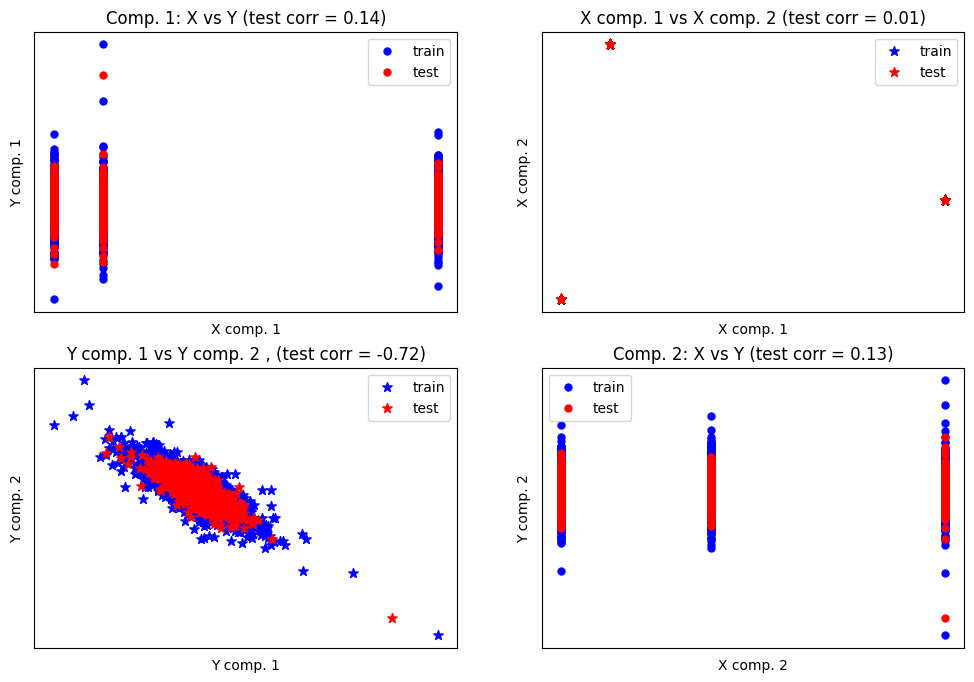

In [16]:
X_train_r, Y_train_r = pls_model.transform(X_train, Y_train)
X_test_r, Y_test_r = pls_model.transform(X_test, Y_test)
plot_scores(X_train_r, Y_train_r, X_test_r, Y_test_r)

### loadings

Text(0.5, 1.0, 'PLS Scores Plot')

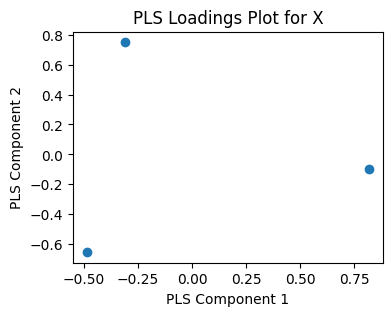

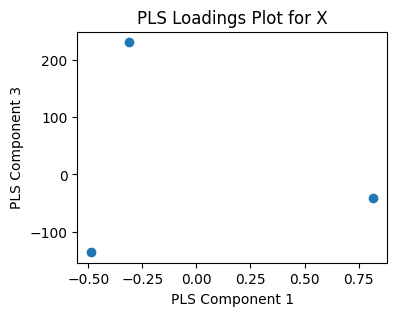

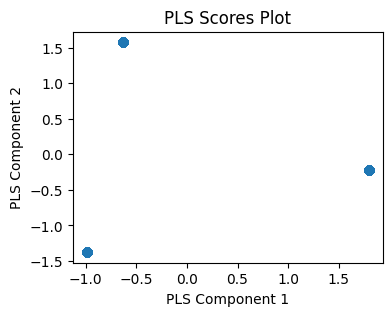

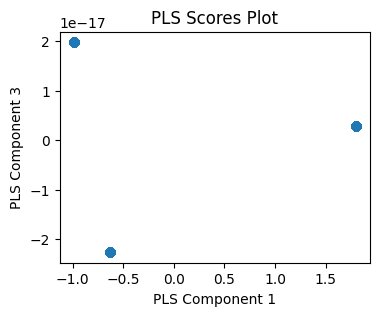

In [17]:
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

# Assume X and Y are your data

# Fit the PLS model
# pls = PLSRegression(n_components=2)
# pls.fit(X, Y)

# Loadings plot for X
plt.figure(figsize=(4,3))
plt.scatter(pls_model.x_loadings_[:, 0], pls_model.x_loadings_[:, 1])
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.title('PLS Loadings Plot for X')
# You can annotate points with variable names here
# plt.show()

# Loadings plot for X
plt.figure(figsize=(4,3))
plt.scatter(pls_model.x_loadings_[:, 0], pls_model.x_loadings_[:, 2])
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 3')
plt.title('PLS Loadings Plot for X')
# You can annotate points with variable names here
# plt.show()

# Scores plot
plt.figure(figsize=(4,3))
plt.scatter(pls_model.x_scores_[:, 0], pls_model.x_scores_[:, 1])
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.title('PLS Scores Plot')
# If you have labels for each sample, you can color code them here
# plt.show()

# Scores plot
plt.figure(figsize=(4,3))
plt.scatter(pls_model.x_scores_[:, 0], pls_model.x_scores_[:, 2])
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 3')
plt.title('PLS Scores Plot')
# If you have labels for each sample, you can color code them here
# plt.show()


### VIP scores

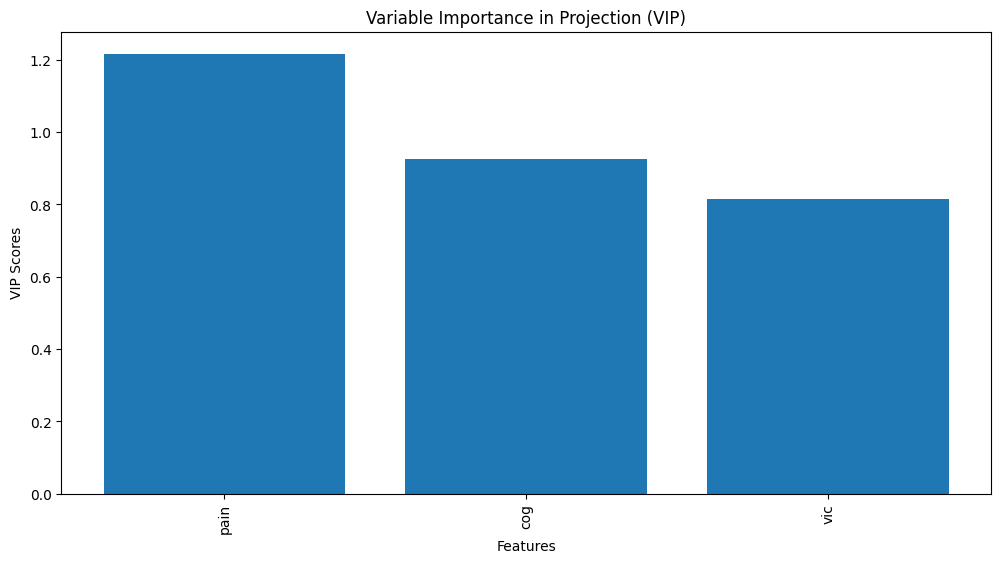

In [18]:
import numpy as np

def calculate_vip(model, X):
    t = model.x_scores_  # scores
    w = model.x_weights_  # weights: projection of the original features onto the latent variables
    q = model.y_loadings_  # y loadings: loadings for response variable. how much each latent variable contributes to explaining varince in Y

    p, h = w.shape
    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([(w[i, j] / np.linalg.norm(w[:, j]))**2 for j in range(h)])
        vips[i] = np.sqrt(p * (s.T @ weight) / total_s) #weighted sum of normalized weights X features.i.e. features' importance

    return vips

import matplotlib.pyplot as plt

# Assuming `pls_model` is your fitted PLS model
vip_scores = calculate_vip(pls_model, X)

# Sort the VIP scores (and keep track of the feature names if you have them)
sorted_indices = np.argsort(vip_scores)[::-1]
sorted_vip_scores = vip_scores[sorted_indices]
feature_names = ["pain", "vic", "cog"]
feature_names_sorted = np.array(feature_names)[sorted_indices]  # Replace feature_names with your actual feature names

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_vip_scores)), sorted_vip_scores, tick_label=feature_names_sorted)
plt.xlabel('Features')
plt.ylabel('VIP Scores')
plt.title('Variable Importance in Projection (VIP)')
plt.xticks(rotation=90)  # Rotate feature names for readability
plt.show()


### Y loadings

In [19]:
len(yloadings)

10

In [20]:
y_loadings = pls_model.y_loadings_


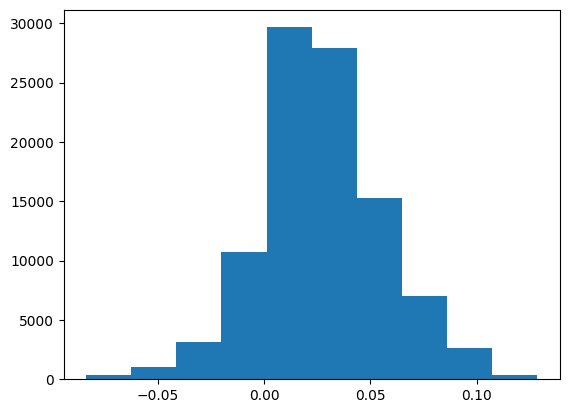

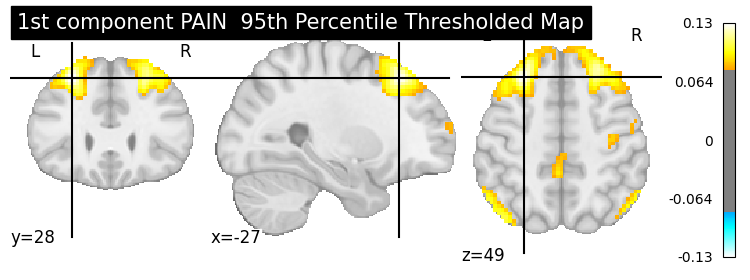

In [23]:
loadings01 = nifti_masker.inverse_transform(y_loadings[:,0])
data = loadings01.get_fdata()
percentile_99 = np.percentile(data[data != 0], 95)  # Exclude zero or background voxels if necessary

# Plot the statistical map using the 95th percentile as the threshold
plt.hist(y_loadings[:,0])
plotting.plot_stat_map(loadings01, threshold=percentile_99, 
             title='1st component PAIN  95th Percentile Thresholded Map')

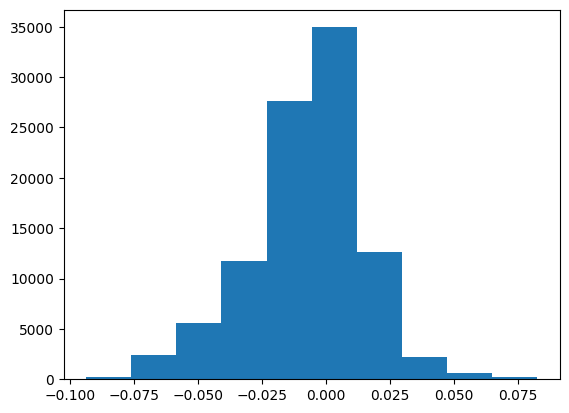

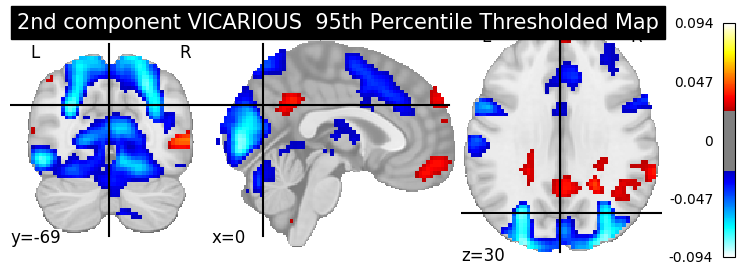

In [24]:
loadings02 = nifti_masker.inverse_transform(y_loadings[:,1])
data = loadings02.get_fdata()
percentile_99 = np.percentile(data[data != 0], 95)  # Exclude zero or background voxels if necessary

# Plot the statistical map using the 95th percentile as the threshold
plt.hist(y_loadings[:,1])
plotting.plot_stat_map(loadings02, threshold=percentile_99, 
             title='2nd component VICARIOUS  95th Percentile Thresholded Map')

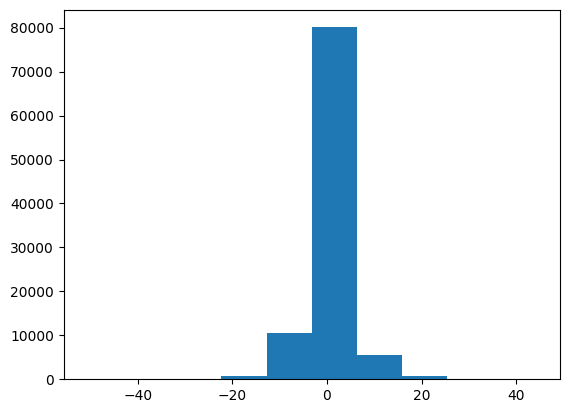

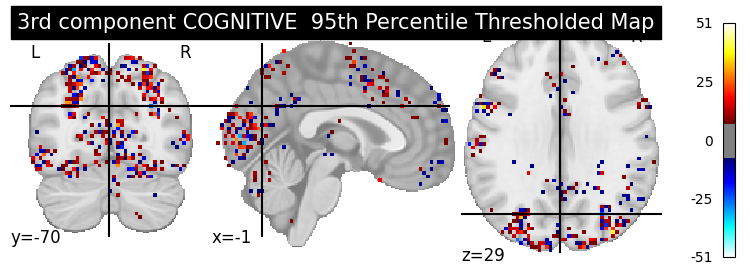

In [25]:
loadings03 = nifti_masker.inverse_transform(y_loadings[:,2])
data = loadings03.get_fdata()
percentile_99 = np.percentile(data[data != 0], 95)  # Exclude zero or background voxels if necessary

# Plot the statistical map using the 95th percentile as the threshold
plt.hist(y_loadings[:,2])
plotting.plot_stat_map(loadings03, threshold=percentile_99, 
             title='3rd component COGNITIVE  95th Percentile Thresholded Map')

# B. ANALYSIS for PVC cue modulation

In [45]:
merged_df

,basename,onset,duration,trial_type,sub,ses,run,runtype,eventtype,trialnum,cuetype,stimtype,expectrating,outcomerating,singletrial_fname,singletrial_fname_no_ext
0,sub-0002_ses-03_run-01_runtype-vicarious_event...,11.61111,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,0,low_cue,low_stim,NaN,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...
1,sub-0002_ses-03_run-01_runtype-vicarious_event...,42.40593,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,1,high_cue,med_stim,NaN,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...
2,sub-0002_ses-03_run-01_runtype-vicarious_event...,74.20112,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,2,high_cue,low_stim,53.370840,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...
3,sub-0002_ses-03_run-01_runtype-vicarious_event...,110.61470,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,3,high_cue,high_stim,36.869898,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...
4,sub-0002_ses-03_run-01_runtype-vicarious_event...,139.90896,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,4,low_cue,med_stim,32.254711,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38851,sub-0133_ses-04_run-06_runtype-cognitive_event...,244.91100,5.0,stimulus,sub-0133,ses-04,run-06,cognitive,stimulus,7,high_cue,low_stim,26.360058,1.847610,sub-0133_ses-04_run-06_runtype-cognitive_event...,sub-0133_ses-04_run-06_runtype-cognitive_event...
38852,sub-0133_ses-04_run-06_runtype-cognitive_event...,280.80772,5.0,stimulus,sub-0133,ses-04,run-06,cognitive,stimulus,8,low_cue,low_stim,8.130102,5.049166,sub-0133_ses-04_run-06_runtype-cognitive_event...,sub-0133_ses-04_run-06_runtype-cognitive_event...
38853,sub-0133_ses-04_run-06_runtype-cognitive_event...,307.90116,5.0,stimulus,sub-0133,ses-04,run-06,cognitive,stimulus,9,high_cue,med_stim,41.919064,9.235559,sub-0133_ses-04_run-06_runtype-cognitive_event...,sub-0133_ses-04_run-06_runtype-cognitive_event...
38854,sub-0133_ses-04_run-06_runtype-cognitive_event...,342.89754,5.0,stimulus,sub-0133,ses-04,run-06,cognitive,stimulus,10,low_cue,med_stim,0.491797,10.350886,sub-0133_ses-04_run-06_runtype-cognitive_event...,sub-0133_ses-04_run-06_runtype-cognitive_event...


In [48]:
import pandas as pd


# Creating the dummy variable for 'pain'
merged_df['pain_cue'] = merged_df.apply(lambda row: 1 if row['runtype'] == 'pain' and row['cuetype'] == 'high_cue' else 
                                      -1 if row['runtype'] == 'pain' and row['cuetype'] == 'low_cue' else 0, axis=1)
merged_df['vic_cue'] = merged_df.apply(lambda row: 1 if row['runtype'] == 'vicarious' and row['cuetype'] == 'high_cue' else 
                                      -1 if row['runtype'] == 'vicarious' and row['cuetype'] == 'low_cue' else 0, axis=1)
merged_df['cog_cue'] = merged_df.apply(lambda row: 1 if row['runtype'] == 'cognitive' and row['cuetype'] == 'high_cue' else 
                                      -1 if row['runtype'] == 'cognitive' and row['cuetype'] == 'low_cue' else 0, axis=1)
merged_df['gen_cue'] = merged_df.apply(lambda row: 1 if row['cuetype'] == 'high_cue' else 
                                      -1 if row['cuetype'] == 'low_cue' else 0, axis=1)

# Display the updated DataFrame
merged_df.head()


,basename,onset,duration,trial_type,sub,ses,run,runtype,eventtype,trialnum,cuetype,stimtype,expectrating,outcomerating,singletrial_fname,singletrial_fname_no_ext,pain_cue,vic_cue,cog_cue,gen_cue
0,sub-0002_ses-03_run-01_runtype-vicarious_event...,11.61111,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,0,low_cue,low_stim,NaN,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,-1,0,-1
1,sub-0002_ses-03_run-01_runtype-vicarious_event...,42.40593,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,1,high_cue,med_stim,NaN,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,1,0,1
2,sub-0002_ses-03_run-01_runtype-vicarious_event...,74.20112,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,2,high_cue,low_stim,53.370840,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,1,0,1
3,sub-0002_ses-03_run-01_runtype-vicarious_event...,110.61470,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,3,high_cue,high_stim,36.869898,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,1,0,1
4,sub-0002_ses-03_run-01_runtype-vicarious_event...,139.90896,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,4,low_cue,med_stim,32.254711,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,-1,0,-1


## B.1 plot behavioral data

In [49]:
Xinterim = merged_df[
    ["pain_cue", "vic_cue", "cog_cue", "gen_cue"]
] 
# TODO: create dummy variables for pain, vicarious, cognitive, general stim
# TODO: create dummy variables for pain, vicarious, cognitive high cue gt low cue

Yinterim = braindf  # zscored_braindf  # np.random.randn(89, 1)      # Replace with your actual data
# identify groups
from collections import Counter

subject_ids = [int(re.search(r"sub-(\d+)", fname).group(1)) for fname in flist]
subject_counts = Counter(subject_ids)  # Count the occurrences of each subject
factorized_ids, unique_ids = pd.factorize(subject_ids)
groupsinterim = (
    factorized_ids + 1
) 

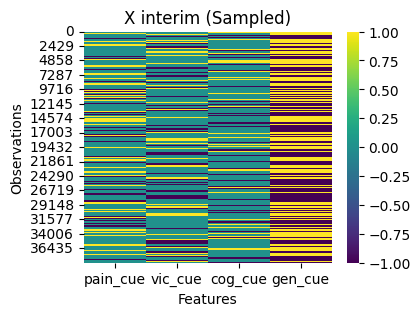

In [50]:

# Plotting
plt.figure(figsize=(4,3))
sns.heatmap(Xinterim, cmap="viridis", cbar=True)
plt.title("X interim (Sampled)")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()


## B.2 remove nan values from matrix

In [51]:
print("7. remove nan values from X and Y")
nan_rows = Xinterim.isnull().any(axis=1)
X = Xinterim[~nan_rows]
Y = Yinterim[~nan_rows]
merged_df[~nan_rows]
groups = groupsinterim[~nan_rows]
clean_indices = nan_rows[~nan_rows].index

# Assuming 'arr' is your NumPy array
# Calculate the mean of each row excluding NaN values
# arr = Y
row_means = np.nanmean(Y, axis=1)
inds = np.where(np.isnan(Y))  # Find the indices where NaN values are present
for i in range(len(inds[0])):  # Replace NaNs with the mean of the corresponding row
    Y[inds[0][i], inds[1][i]] = row_means[inds[0][i]]


7. remove nan values from X and Y


## B.3 PLS for PVC cue contrast

In [53]:


outer_cv = GroupKFold(n_splits=5)
pls_model = PLSRegression(n_components=4)
i = 0
inner_scores = []
outer_scores = []
weights_per_fold = []
coefficients = []

# X = braindf
# Y = reg
for i, (train_val_idx, test_idx) in enumerate(outer_cv.split(X, Y, groups)):
    print(f"________________________________ fold {i} ________________________________")
    X_train, X_test = X.iloc[train_val_idx].to_numpy(), X.iloc[test_idx].to_numpy()
    Y_train, Y_test = Y[train_val_idx], Y[test_idx]
    groups_train_val = groups[train_val_idx]
    print(
        f"train participants: {np.unique(groups[train_val_idx])},test participants: {np.unique(groups[test_idx])}, "
    )
    # Fit the model
    pls_model.fit(X_train, Y_train)
    coefficients.append(pls_model.coef_)
    # Evaluate on the inner validation set
    Y_pred = pls_model.predict(X_test)
    inner_score = mean_squared_error(Y_test, Y_pred)
    inner_scores.append(inner_score)
    # Assuming the nifti_masker has been fitted previously
    y_weights = pls_model.y_weights_
    weights = pls_model.x_weights_
    weights_per_fold.append(weights)

    x_weights_first_component = pls_model.x_weights_[:, 0]
    y_weights_first_component = pls_model.y_weights_[:, 0]

    x_weights_second_component = pls_model.x_weights_[:, 1]
    y_weights_second_component = pls_model.y_weights_[:, 1]

    x_weights_third_component = pls_model.x_weights_[:, 2]
    y_weights_third_component = pls_model.y_weights_[:, 2]

#     first_img = nifti_masker.inverse_transform(x_weights_first_component)
#     second_img = nifti_masker.inverse_transform(x_weights_second_component)
#     third_img = nifti_masker.inverse_transform(x_weights_third_component)

________________________________ fold 0 ________________________________
train participants: [  1   2   3   4   5   9  10  11  13  14  15  16  17  18  19  20  21  22
  23  24  26  27  28  29  31  32  33  34  35  36  37  38  40  41  42  43
  45  46  47  48  49  51  54  55  56  57  58  59  60  61  62  63  66  67
  68  69  70  71  73  74  75  76  77  79  80  81  83  84  85  86  87  88
  89  90  91  92  94  95  97  98  99 101 102 103 104 105 106 108 110],test participants: [  6   7   8  12  25  30  39  44  50  52  53  64  65  72  78  82  93  96
 100 107 109 111], 
________________________________ fold 1 ________________________________
train participants: [  1   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41
  42  44  45  46  47  48  50  51  52  53  54  55  56  58  59  60  61  62
  64  65  66  67  68  69  72  73  74  76  77  78  80  81  82  84  85  86
  89  90  91  93  94  96  97  98 100 101 102 103

## B.4 visualization

### B.4.a scores

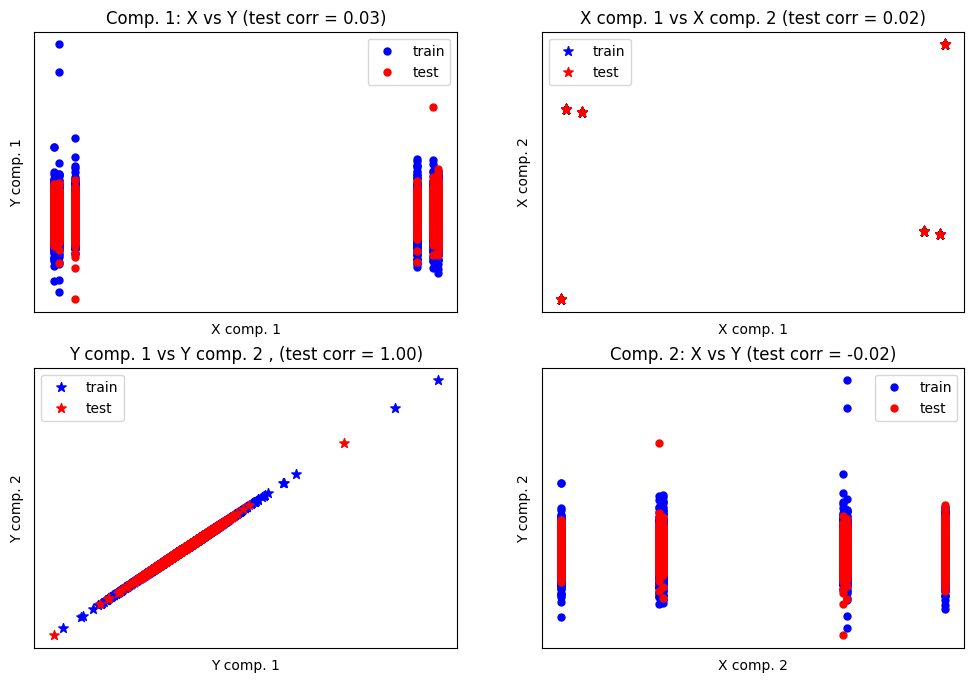

In [54]:
X_train_r, Y_train_r = pls_model.transform(X_train, Y_train)
X_test_r, Y_test_r = pls_model.transform(X_test, Y_test)
plot_scores(X_train_r, Y_train_r, X_test_r, Y_test_r)

### B.4.b plot loadings

Text(0.5, 1.0, 'PLS Scores Plot')

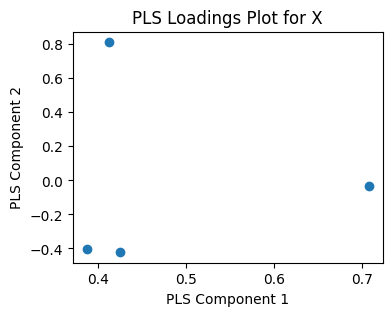

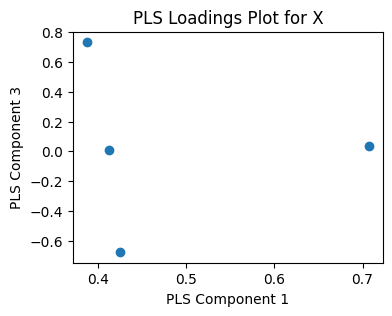

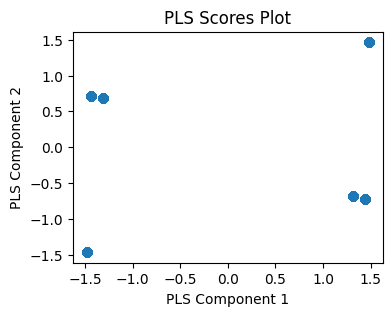

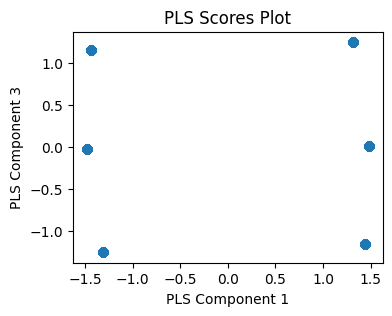

In [59]:
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

# Assume X and Y are your data

# Fit the PLS model
# pls = PLSRegression(n_components=2)
# pls.fit(X, Y)

# Loadings plot for X
plt.figure(figsize=(4,3))
plt.scatter(pls_model.x_loadings_[:, 0], pls_model.x_loadings_[:, 1])
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.title('PLS Loadings Plot for X')
# You can annotate points with variable names here
# plt.show()

# Loadings plot for X
plt.figure(figsize=(4,3))
plt.scatter(pls_model.x_loadings_[:, 0], pls_model.x_loadings_[:, 2])
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 3')
plt.title('PLS Loadings Plot for X')
# You can annotate points with variable names here
# plt.show()

# Scores plot
plt.figure(figsize=(4,3))
plt.scatter(pls_model.x_scores_[:, 0], pls_model.x_scores_[:, 1])
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.title('PLS Scores Plot')
# If you have labels for each sample, you can color code them here
# plt.show()

# Scores plot
plt.figure(figsize=(4,3))
plt.scatter(pls_model.x_scores_[:, 0], pls_model.x_scores_[:, 2])
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 3')
plt.title('PLS Scores Plot')
# If you have labels for each sample, you can color code them here
# plt.show()


### B.4.c VIP scores

Variable Importance in Projection (VIP) scores 

VIP score: measures the importance of each feature in pLS-R with respect to predictive power of model. 
Which feature contributes most to the model's ability to predict response variables

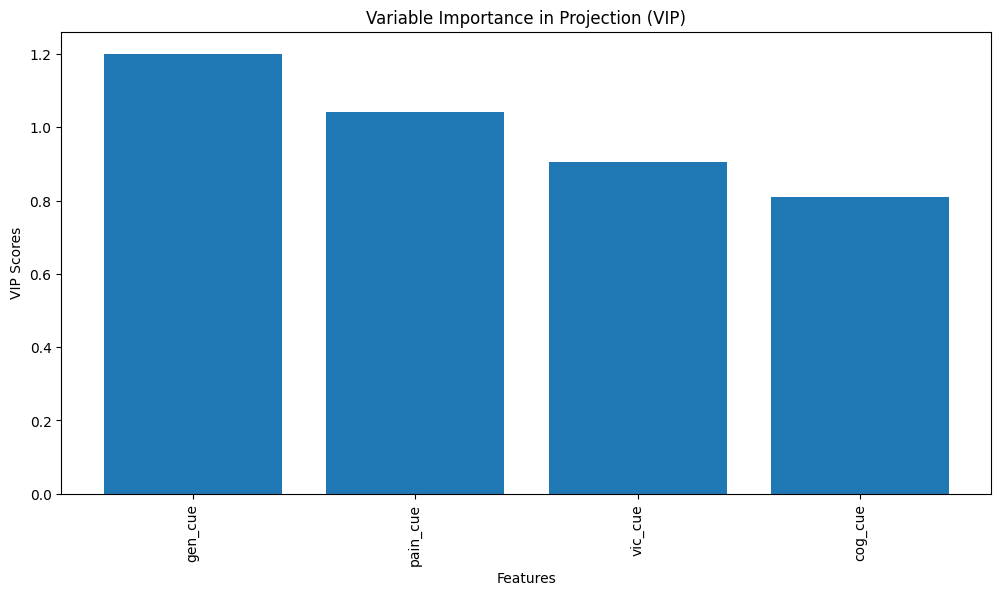

In [60]:
import numpy as np

def calculate_vip(model, X):
    t = model.x_scores_  # scores
    w = model.x_weights_  # weights
    q = model.y_loadings_  # y loadings

    p, h = w.shape
    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([(w[i, j] / np.linalg.norm(w[:, j]))**2 for j in range(h)])
        vips[i] = np.sqrt(p * (s.T @ weight) / total_s)

    return vips

import matplotlib.pyplot as plt

# Assuming `pls_model` is your fitted PLS model
vip_scores = calculate_vip(pls_model, X)

# Sort the VIP scores (and keep track of the feature names if you have them)
sorted_indices = np.argsort(vip_scores)[::-1]
sorted_vip_scores = vip_scores[sorted_indices]
feature_names = ["pain_cue", "vic_cue", "cog_cue", "gen_cue"]
feature_names_sorted = np.array(feature_names)[sorted_indices]  # Replace feature_names with your actual feature names

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_vip_scores)), sorted_vip_scores, tick_label=feature_names_sorted)
plt.xlabel('Features')
plt.ylabel('VIP Scores')
plt.title('Variable Importance in Projection (VIP)')
plt.xticks(rotation=90)  # Rotate feature names for readability
plt.show()


### B.4.d beta maps

/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `y_mean_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


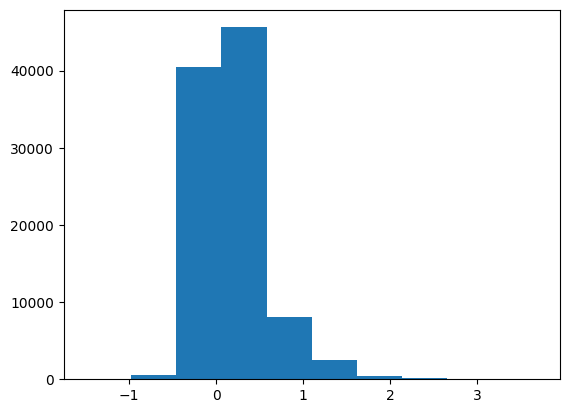

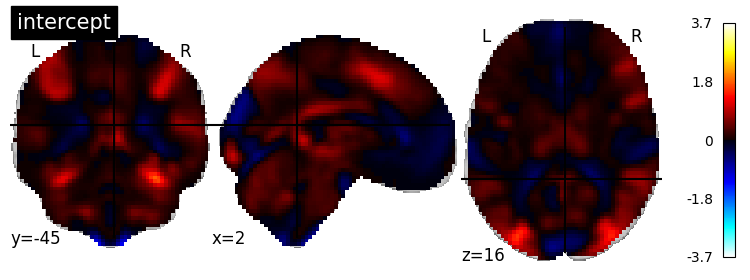

In [66]:
# https://stackoverflow.com/questions/41188410/how-obtain-the-intercept-of-the-pls-regression-sklearn
intercept = nifti_masker.inverse_transform(pls_model.y_mean_)
plt.hist(pls_model.y_mean_)
plotting.plot_stat_map(intercept,  title="intercept")

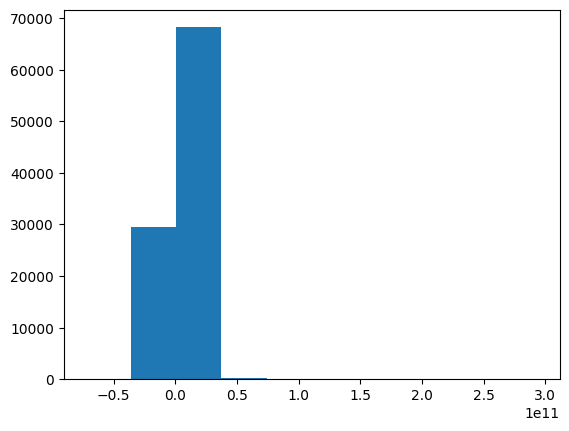

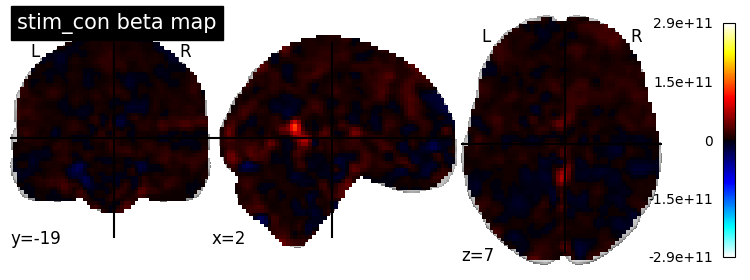

In [67]:
first_img_beta = nifti_masker.inverse_transform(coefficients[1][0,:])
plt.hist(coefficients[1][0,:])
plotting.plot_stat_map(first_img_beta, threshold=0.01, title="stim_con beta map")

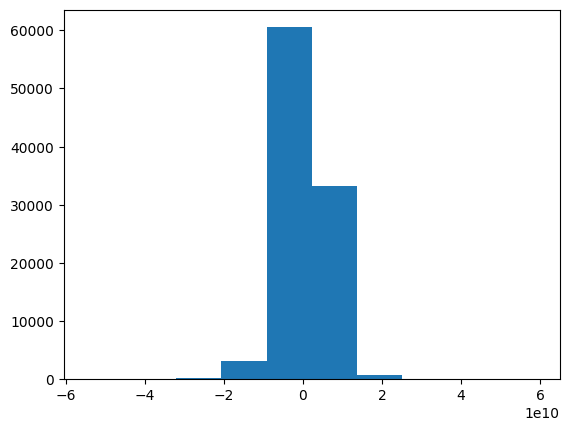

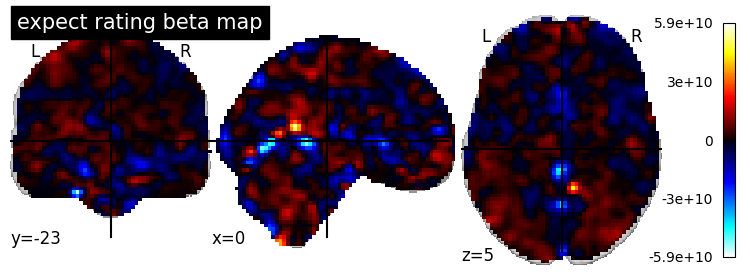

In [68]:
second_img_beta = nifti_masker.inverse_transform(coefficients[0][1,:])
plt.hist(coefficients[0][1,:])
plotting.plot_stat_map(second_img_beta, threshold=0.02, title="expect rating beta map")

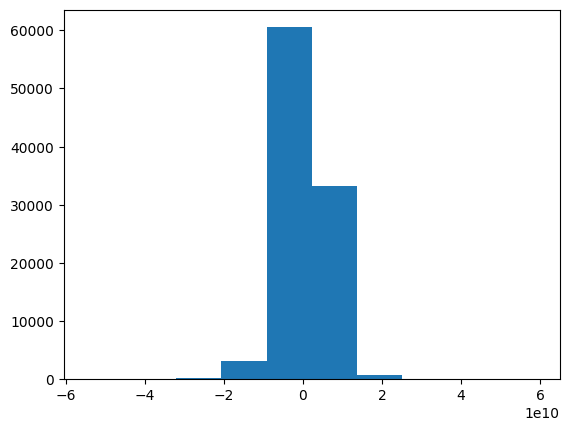

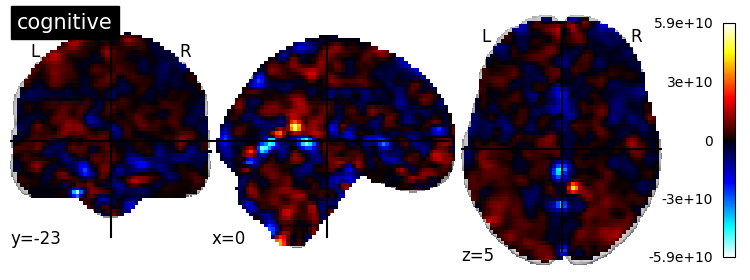

In [72]:
third_img_beta = nifti_masker.inverse_transform(coefficients[0][2,:])
plt.hist(coefficients[0][2,:])
plotting.plot_stat_map(third_img_beta, threshold=2, title="cognitive")

In [ ]:
fourth_img_beta = nifti_masker.inverse_transform(coefficients[0][3,:])
plt.hist(coefficients[0][3,:])
plotting.plot_stat_map(fourth_img_beta, threshold=0.1, title="cognitive")

### B.4.e Y loadings

In [61]:
y_loadings = pls_model.y_loadings_


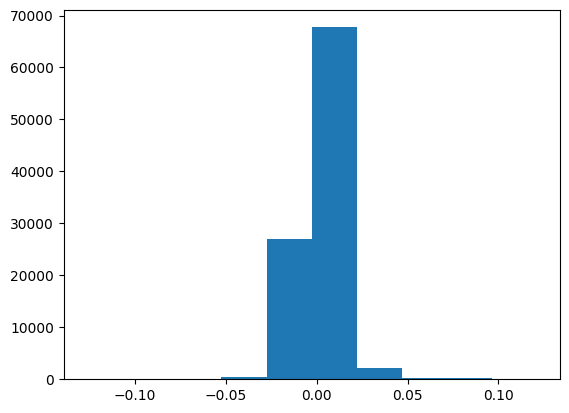

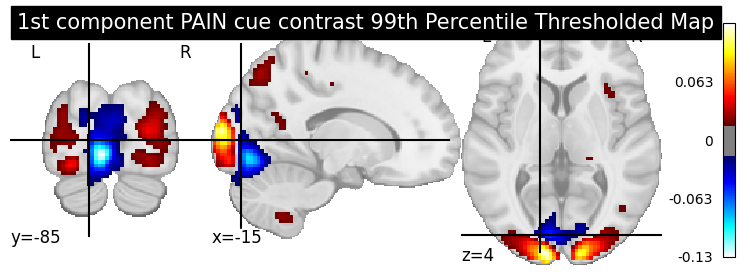

In [74]:
loadings01 = nifti_masker.inverse_transform(y_loadings[:,0])
data = loadings01.get_fdata()
percentile_99 = np.percentile(data[data != 0], 95)  # Exclude zero or background voxels if necessary

# Plot the statistical map using the 95th percentile as the threshold
plt.hist(y_loadings[:,0])
plotting.plot_stat_map(loadings01, threshold=percentile_99, 
             title='1st component PAIN cue contrast 99th Percentile Thresholded Map')

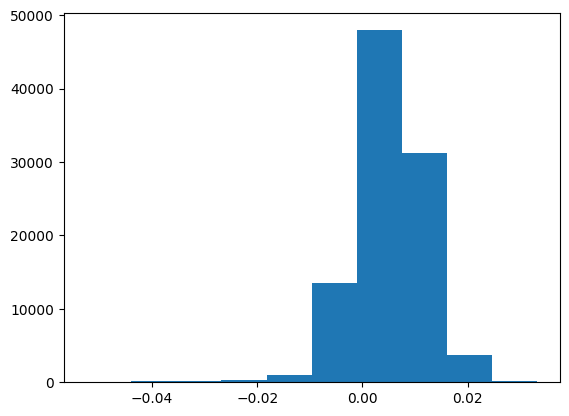

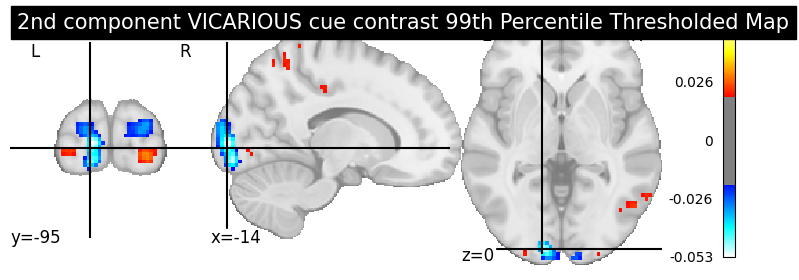

In [73]:
loadings02 = nifti_masker.inverse_transform(y_loadings[:,1])
data = loadings02.get_fdata()
percentile_99 = np.percentile(data[data != 0], 95)  # Exclude zero or background voxels if necessary

# Plot the statistical map using the 95th percentile as the threshold
plt.hist(y_loadings[:,1])
plotting.plot_stat_map(loadings02, threshold=percentile_99, 
             title='2nd component VICARIOUS cue contrast 99th Percentile Thresholded Map')

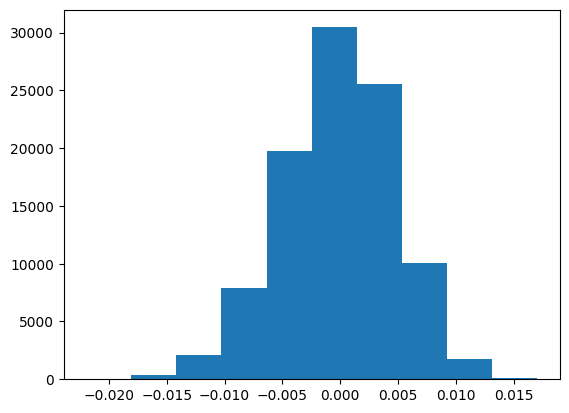

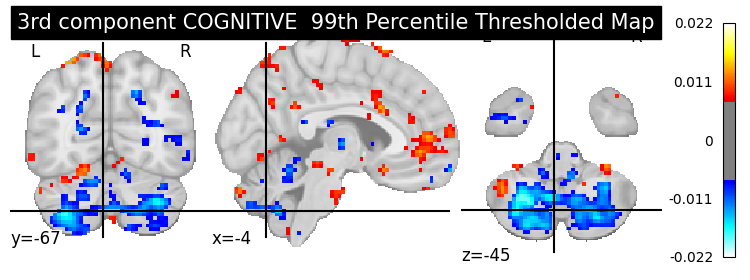

In [75]:
loadings03 = nifti_masker.inverse_transform(y_loadings[:,2])
data = loadings03.get_fdata()
percentile_99 = np.percentile(data[data != 0], 95)  # Exclude zero or background voxels if necessary

# Plot the statistical map using the 95th percentile as the threshold
plt.hist(y_loadings[:,2])
plotting.plot_stat_map(loadings03, threshold=percentile_99, 
             title='3rd component COGNITIVE  99th Percentile Thresholded Map')

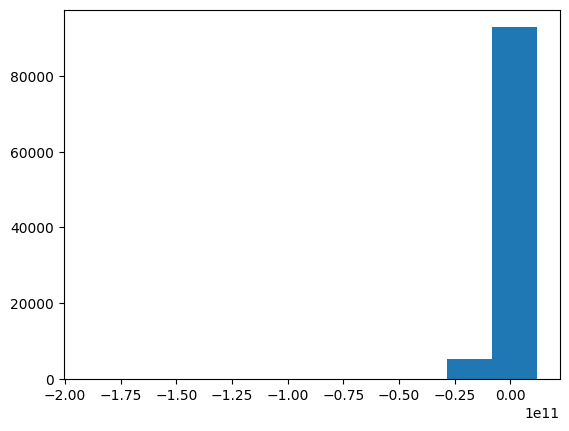

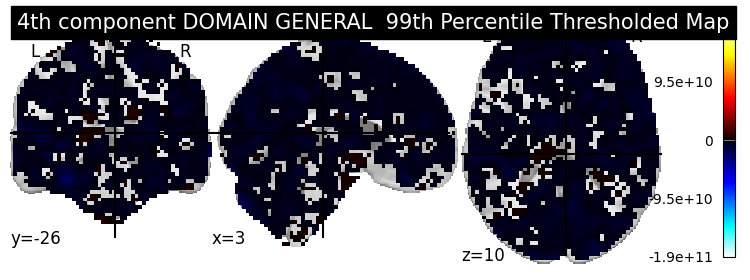

In [76]:
loadings04 = nifti_masker.inverse_transform(y_loadings[:,3])
data = loadings04.get_fdata()
percentile_99 = np.percentile(data[data != 0], 95)  # Exclude zero or background voxels if necessary

# Plot the statistical map using the 95th percentile as the threshold
plt.hist(y_loadings[:,3])
plotting.plot_stat_map(loadings04, threshold=percentile_99, 
             title='4th component DOMAIN GENERAL  99th Percentile Thresholded Map')